In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 96
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

DATASET_DIR_NAME = "dataset\set03\\01_original_rand"
SAMPLE_DATASET_NAME = "original_train_rand"
ACTUAL_DATASET_NAME = "original_test_rand"

MODEL_DIR_NAME = "dataset\set03\\01_original_rand"
MODEL_NAME = "model_" + "set03_01_original_rand"

RESULT_DIR_NAME = "dataset\set03\\01_original_rand"
RESULT_NAME = "result_" + "set03_01_original_rand"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\01_original_rand
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\01_original_rand
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\01_original_rand\original_train_rand.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4
0,adhy,apish,0.176624,-0.081235,0.095389,0.054188,0.230811,0.135423,-0.079058,0.056365,...,0.000098,0.001523,0.006877,0.022257,0.009891,0.039024,0.183280,0.359904,0.271153,0.447777
1,adhy,aargh,0.120374,0.072112,0.192487,0.239215,0.359589,0.167103,-0.032174,0.134929,...,0.018428,0.010549,0.106929,0.073887,0.135748,0.102706,0.568097,0.688471,0.671329,0.791703
2,adhy,terry,0.103403,-0.015979,0.087424,0.152003,0.255405,0.167982,-0.032004,0.135978,...,0.009239,0.002546,0.056287,0.010623,0.096118,0.050453,0.328402,0.431805,0.384529,0.487932
3,adhy,decaf,0.095771,0.079566,0.175337,0.175467,0.271238,0.095901,0.121074,0.216976,...,0.004547,0.004534,0.078745,0.078653,0.067429,0.067337,0.519806,0.615577,0.648569,0.744340
4,adhy,muser,0.112793,0.087803,0.200596,0.192014,0.304807,0.104211,0.071961,0.176172,...,0.012902,0.014318,0.045071,0.051139,0.113588,0.119657,0.448259,0.561053,0.519647,0.632440


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


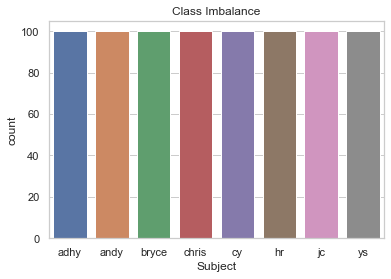

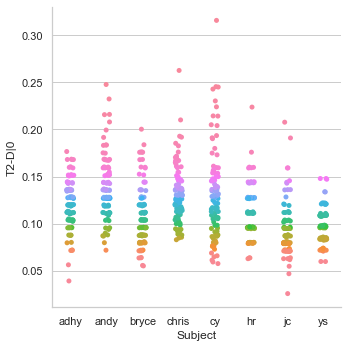

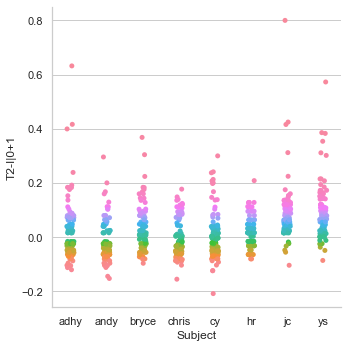

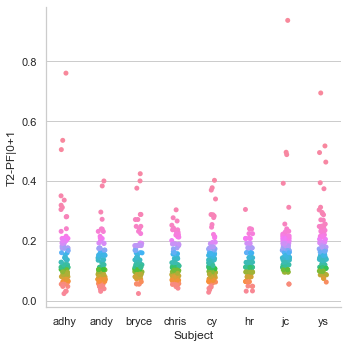

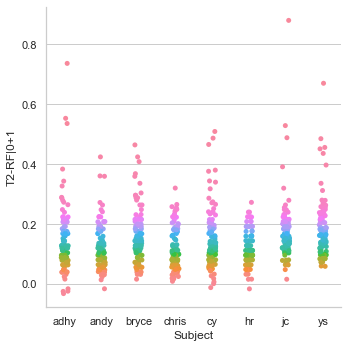

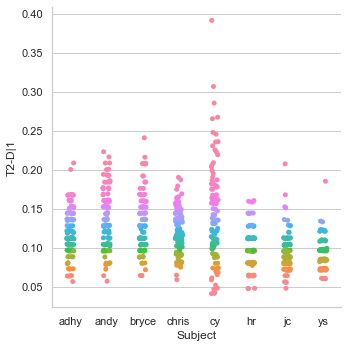

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (800, 96)
Y | Classes  | Dataset Shape: (800, 8)
Number of Classes: 8


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (640, 1, 96)
Y train shape: (640, 8)
X test shape: (160, 1, 96)
Y test shape: (160, 8)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 8 classes.
Epoch 1/200
6/6 [==============================] - 6s 15ms/step - loss: 2.2463 - accuracy: 0.1152
Epoch 2/200
6/6 [==============================] - 0s 15ms/step - loss: 2.2618 - accuracy: 0.1367
Epoch 3/200
6/6 [==============================] - 0s 14ms/step - loss: 2.1888 - accuracy: 0.1348
Epoch 4/200
6/6 [==============================] - 0s 12ms/step - loss: 2.1901 - accuracy: 0.1230
Epoch 5/200
6/6 [==============================] - 0s 12ms/step - loss: 2.1493 - accuracy: 0.1309
Epoch 6/200
6/6 [==============================] - 0s 13ms/step - loss: 2.1583 - accuracy: 0.1152
Epoch 7/200
6/6 [==============================] - 0s 14ms/step - loss: 2.1138 - accuracy: 0.1270
Epoch 8/200
6/6 [==============================] - 0s 13ms/step - loss: 2.1383 - accuracy: 0.1328
Epoch 9/200
6/6 [==============================] - 0s 14ms/step - loss: 2.1330 - accuracy: 0.1230
Epoch 10/200
6/6 [==============================] - 0s 14ms/step - loss: 2.1396 - accu

6/6 [==============================] - 0s 13ms/step - loss: 1.8098 - accuracy: 0.2344
Epoch 84/200
6/6 [==============================] - 0s 13ms/step - loss: 1.8026 - accuracy: 0.2461
Epoch 85/200
6/6 [==============================] - 0s 13ms/step - loss: 1.8040 - accuracy: 0.2402
Epoch 86/200
6/6 [==============================] - 0s 14ms/step - loss: 1.8047 - accuracy: 0.2305
Epoch 87/200
6/6 [==============================] - 0s 13ms/step - loss: 1.7961 - accuracy: 0.2598
Epoch 88/200
6/6 [==============================] - 0s 13ms/step - loss: 1.7745 - accuracy: 0.2539
Epoch 89/200
6/6 [==============================] - 0s 13ms/step - loss: 1.7859 - accuracy: 0.2637
Epoch 90/200
6/6 [==============================] - 0s 13ms/step - loss: 1.7946 - accuracy: 0.2559
Epoch 91/200
6/6 [==============================] - 0s 13ms/step - loss: 1.8121 - accuracy: 0.2344
Epoch 92/200
6/6 [==============================] - 0s 13ms/step - loss: 1.7905 - accuracy: 0.2402
Epoch 93/200
6/6 [=====

6/6 [==============================] - 0s 14ms/step - loss: 1.6772 - accuracy: 0.3027
Epoch 166/200
6/6 [==============================] - 0s 13ms/step - loss: 1.6737 - accuracy: 0.3008
Epoch 167/200
6/6 [==============================] - 0s 13ms/step - loss: 1.6703 - accuracy: 0.3457
Epoch 168/200
6/6 [==============================] - 0s 13ms/step - loss: 1.6523 - accuracy: 0.3086
Epoch 169/200
6/6 [==============================] - 0s 13ms/step - loss: 1.6990 - accuracy: 0.2949
Epoch 170/200
6/6 [==============================] - 0s 13ms/step - loss: 1.6674 - accuracy: 0.3047
Epoch 171/200
6/6 [==============================] - 0s 14ms/step - loss: 1.6876 - accuracy: 0.2812
Epoch 172/200
6/6 [==============================] - 0s 14ms/step - loss: 1.6862 - accuracy: 0.2734
Epoch 173/200
6/6 [==============================] - 0s 13ms/step - loss: 1.6764 - accuracy: 0.2988
Epoch 174/200
6/6 [==============================] - 0s 13ms/step - loss: 1.6505 - accuracy: 0.2793
Epoch 175/200


6/6 [==============================] - 0s 14ms/step - loss: 1.9398 - accuracy: 0.2148
Epoch 47/200
6/6 [==============================] - 0s 14ms/step - loss: 1.9566 - accuracy: 0.2070
Epoch 48/200
6/6 [==============================] - 0s 14ms/step - loss: 1.9110 - accuracy: 0.2207
Epoch 49/200
6/6 [==============================] - 0s 14ms/step - loss: 1.9079 - accuracy: 0.2363
Epoch 50/200
6/6 [==============================] - 0s 13ms/step - loss: 1.8785 - accuracy: 0.2344
Epoch 51/200
6/6 [==============================] - 0s 13ms/step - loss: 1.9231 - accuracy: 0.2109
Epoch 52/200
6/6 [==============================] - 0s 16ms/step - loss: 1.9436 - accuracy: 0.2031
Epoch 53/200
6/6 [==============================] - 0s 16ms/step - loss: 1.9160 - accuracy: 0.2305
Epoch 54/200
6/6 [==============================] - 0s 14ms/step - loss: 1.8768 - accuracy: 0.2305
Epoch 55/200
6/6 [==============================] - 0s 14ms/step - loss: 1.8763 - accuracy: 0.2188
Epoch 56/200
6/6 [=====

6/6 [==============================] - 0s 15ms/step - loss: 1.6862 - accuracy: 0.3145
Epoch 129/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6998 - accuracy: 0.3027
Epoch 130/200
6/6 [==============================] - 0s 14ms/step - loss: 1.7280 - accuracy: 0.3066
Epoch 131/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6935 - accuracy: 0.2871
Epoch 132/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6751 - accuracy: 0.3066
Epoch 133/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6967 - accuracy: 0.3145
Epoch 134/200
6/6 [==============================] - 0s 14ms/step - loss: 1.6904 - accuracy: 0.3125
Epoch 135/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6997 - accuracy: 0.2949
Epoch 136/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6526 - accuracy: 0.3340
Epoch 137/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6599 - accuracy: 0.3027
Epoch 138/200


6/6 [==============================] - 0s 15ms/step - loss: 2.1526 - accuracy: 0.1191
Epoch 10/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1519 - accuracy: 0.1074
Epoch 11/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1251 - accuracy: 0.1035
Epoch 12/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1295 - accuracy: 0.1582
Epoch 13/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1228 - accuracy: 0.1152
Epoch 14/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1313 - accuracy: 0.1328
Epoch 15/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1148 - accuracy: 0.1270
Epoch 16/200
6/6 [==============================] - 0s 16ms/step - loss: 2.1137 - accuracy: 0.1152
Epoch 17/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1218 - accuracy: 0.1094
Epoch 18/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1206 - accuracy: 0.1387
Epoch 19/200
6/6 [=====

6/6 [==============================] - 0s 15ms/step - loss: 1.7174 - accuracy: 0.3164
Epoch 92/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7273 - accuracy: 0.3047
Epoch 93/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7097 - accuracy: 0.3105
Epoch 94/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6940 - accuracy: 0.3105
Epoch 95/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6921 - accuracy: 0.3223
Epoch 96/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6960 - accuracy: 0.3008
Epoch 97/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7124 - accuracy: 0.2754
Epoch 98/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6974 - accuracy: 0.3086
Epoch 99/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7146 - accuracy: 0.3164
Epoch 100/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6889 - accuracy: 0.3379
Epoch 101/200
6/6 [===

6/6 [==============================] - 0s 15ms/step - loss: 1.6463 - accuracy: 0.3301
Epoch 174/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6080 - accuracy: 0.3574
Epoch 175/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6004 - accuracy: 0.3379
Epoch 176/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6098 - accuracy: 0.3535
Epoch 177/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6491 - accuracy: 0.3301
Epoch 178/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6325 - accuracy: 0.3398
Epoch 179/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6281 - accuracy: 0.3184
Epoch 180/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6251 - accuracy: 0.3164
Epoch 181/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6508 - accuracy: 0.3164
Epoch 182/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6315 - accuracy: 0.3457
Epoch 183/200


6/6 [==============================] - 0s 15ms/step - loss: 1.8471 - accuracy: 0.2520
Epoch 55/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7939 - accuracy: 0.2598
Epoch 56/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8142 - accuracy: 0.2344
Epoch 57/200
6/6 [==============================] - 0s 14ms/step - loss: 1.8477 - accuracy: 0.2305
Epoch 58/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8309 - accuracy: 0.2695
Epoch 59/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8322 - accuracy: 0.2461
Epoch 60/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7905 - accuracy: 0.2500
Epoch 61/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8101 - accuracy: 0.2598
Epoch 62/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8106 - accuracy: 0.2695
Epoch 63/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8028 - accuracy: 0.2676
Epoch 64/200
6/6 [=====

6/6 [==============================] - 0s 14ms/step - loss: 1.6979 - accuracy: 0.2930
Epoch 137/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7034 - accuracy: 0.2930
Epoch 138/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7276 - accuracy: 0.2871
Epoch 139/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7075 - accuracy: 0.3125
Epoch 140/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6972 - accuracy: 0.3203
Epoch 141/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7064 - accuracy: 0.3125
Epoch 142/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6771 - accuracy: 0.3203
Epoch 143/200
6/6 [==============================] - 0s 14ms/step - loss: 1.7049 - accuracy: 0.3184
Epoch 144/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7319 - accuracy: 0.3105
Epoch 145/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7158 - accuracy: 0.3008
Epoch 146/200


6/6 [==============================] - 0s 16ms/step - loss: 2.1301 - accuracy: 0.1211
Epoch 18/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1121 - accuracy: 0.1465
Epoch 19/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1101 - accuracy: 0.1309
Epoch 20/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1178 - accuracy: 0.1270
Epoch 21/200
6/6 [==============================] - 0s 15ms/step - loss: 2.0990 - accuracy: 0.1641
Epoch 22/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1180 - accuracy: 0.1113
Epoch 23/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1131 - accuracy: 0.1270
Epoch 24/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1309 - accuracy: 0.1191
Epoch 25/200
6/6 [==============================] - 0s 16ms/step - loss: 2.1252 - accuracy: 0.1211
Epoch 26/200
6/6 [==============================] - 0s 15ms/step - loss: 2.1220 - accuracy: 0.1230
Epoch 27/200
6/6 [=====

6/6 [==============================] - 0s 16ms/step - loss: 1.7843 - accuracy: 0.2598
Epoch 100/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7592 - accuracy: 0.2832
Epoch 101/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7430 - accuracy: 0.2930
Epoch 102/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7395 - accuracy: 0.2480
Epoch 103/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7583 - accuracy: 0.2852
Epoch 104/200
6/6 [==============================] - 0s 16ms/step - loss: 1.7513 - accuracy: 0.2520
Epoch 105/200
6/6 [==============================] - 0s 16ms/step - loss: 1.7214 - accuracy: 0.2812
Epoch 106/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7443 - accuracy: 0.3027
Epoch 107/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7048 - accuracy: 0.2910
Epoch 108/200
6/6 [==============================] - 0s 15ms/step - loss: 1.7429 - accuracy: 0.2676
Epoch 109/200


6/6 [==============================] - 0s 15ms/step - loss: 1.6495 - accuracy: 0.2910
Epoch 182/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6486 - accuracy: 0.2949
Epoch 183/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6325 - accuracy: 0.3086
Epoch 184/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6447 - accuracy: 0.3379
Epoch 185/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6137 - accuracy: 0.3184
Epoch 186/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6089 - accuracy: 0.3066
Epoch 187/200
6/6 [==============================] - 0s 14ms/step - loss: 1.6259 - accuracy: 0.3184
Epoch 188/200
6/6 [==============================] - 0s 14ms/step - loss: 1.6440 - accuracy: 0.2832
Epoch 189/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6297 - accuracy: 0.3184
Epoch 190/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6352 - accuracy: 0.2988
Epoch 191/200


##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 26.88% (with standard deviation of 5.60%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 8 classes.
Epoch 1/200
7/7 [==============================] - 6s 17ms/step - loss: 2.3857 - accuracy: 0.1297
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 2.2977 - accuracy: 0.1344
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 2.2421 - accuracy: 0.1344
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 2.2058 - accuracy: 0.1250
Epoch 5/200
7/7 [==============================] - 0s 15ms/step - loss: 2.1800 - accuracy: 0.1047
Epoch 6/200
7/7 [==============================] - 0s 15ms/step - loss: 2.1790 - accuracy: 0.1109
Epoch 7/200
7/7 [==============================] - 0s 16ms/step - loss: 2.1374 - accuracy: 0.1312
Epoch 8/200
7/7 [==============================] - 0s 15ms/step - loss: 2.1560 - accuracy: 0.1219
Epoch 9/200
7/7 [==============================] - 0s 16ms/step - loss: 2.1195 - accuracy: 0.1250
Epoch 10/200
7/7 [==============================] - 0s 15ms/step - loss: 2.1208 - accu

7/7 [==============================] - 0s 15ms/step - loss: 1.6914 - accuracy: 0.3109
Epoch 84/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6898 - accuracy: 0.2969
Epoch 85/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6912 - accuracy: 0.3000
Epoch 86/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6947 - accuracy: 0.3000
Epoch 87/200
7/7 [==============================] - 0s 15ms/step - loss: 1.7075 - accuracy: 0.2828
Epoch 88/200
7/7 [==============================] - 0s 15ms/step - loss: 1.7259 - accuracy: 0.2578
Epoch 89/200
7/7 [==============================] - 0s 15ms/step - loss: 1.7203 - accuracy: 0.2906
Epoch 90/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6895 - accuracy: 0.3016
Epoch 91/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6853 - accuracy: 0.3000
Epoch 92/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6609 - accuracy: 0.3187
Epoch 93/200
7/7 [=====

7/7 [==============================] - 0s 15ms/step - loss: 1.5999 - accuracy: 0.3406
Epoch 166/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6252 - accuracy: 0.3219
Epoch 167/200
7/7 [==============================] - 0s 16ms/step - loss: 1.5912 - accuracy: 0.3391
Epoch 168/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6194 - accuracy: 0.3297
Epoch 169/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6053 - accuracy: 0.3469
Epoch 170/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6153 - accuracy: 0.3375
Epoch 171/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6135 - accuracy: 0.3500
Epoch 172/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6097 - accuracy: 0.3359
Epoch 173/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6064 - accuracy: 0.3391
Epoch 174/200
7/7 [==============================] - 0s 15ms/step - loss: 1.6174 - accuracy: 0.3328
Epoch 175/200


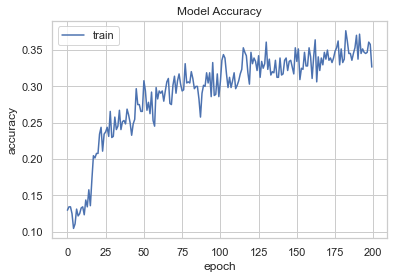

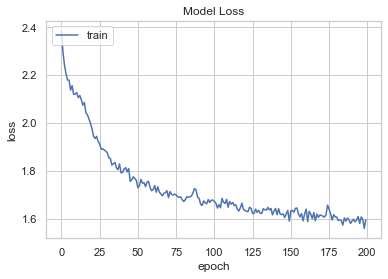

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            361472    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 31.875%


##### Confusion Matrix

160 is the number of test value in kfold_val / train_test_split


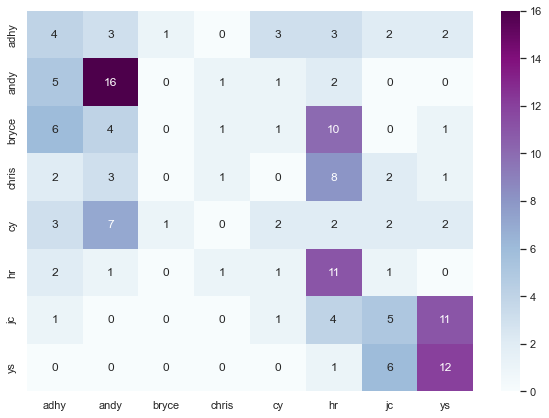

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

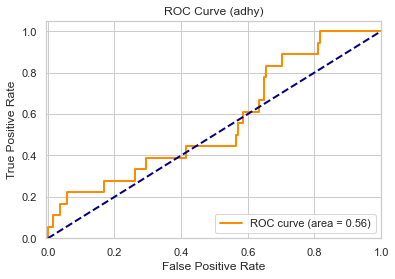

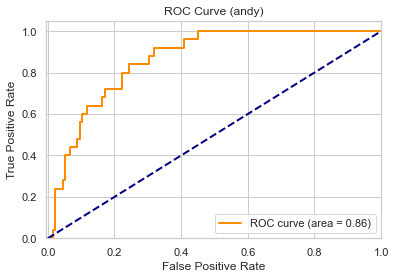

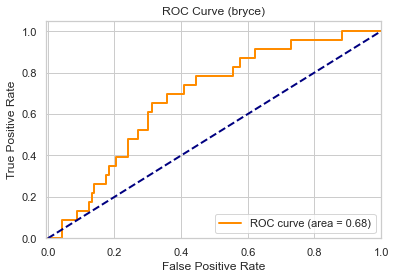

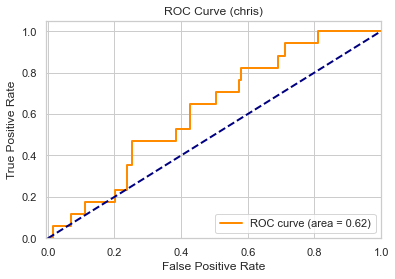

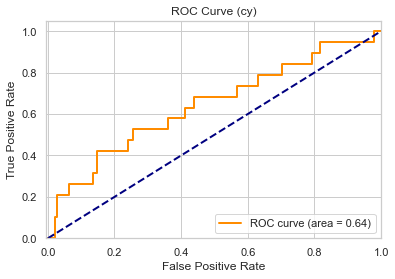

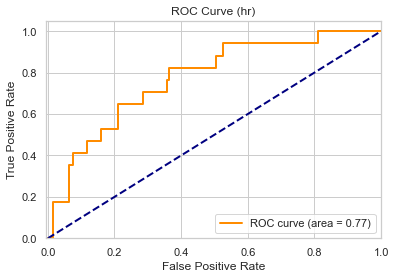

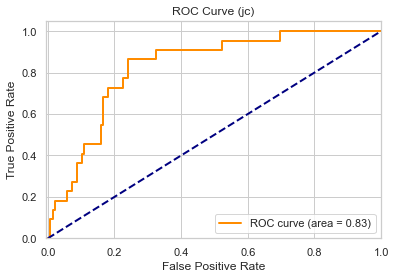

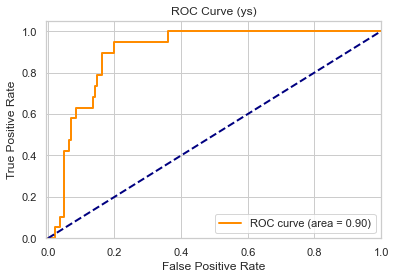

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

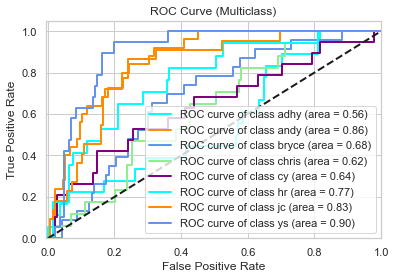

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

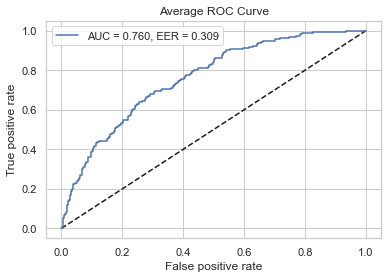

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (800, 96)
Y | Classes  | Dataset Shape: (800, 8)
There are a total of 8 classes.
Epoch 1/200
8/8 [==============================] - 4s 14ms/step - loss: 2.4111 - accuracy: 0.1250
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 2.3332 - accuracy: 0.1375
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 2.2549 - accuracy: 0.1262
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 2.2189 - accuracy: 0.1312
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 2.1860 - accuracy: 0.1200
Epoch 6/200
8/8 [==============================] - 0s 13ms/step - loss: 2.1557 - accuracy: 0.1388
Epoch 7/200
8/8 [==============================] - 0s 13ms/step - loss: 2.1600 - accuracy: 0.1225
Epoch 8/200
8/8 [==============================] - 0s 13ms/step - loss: 2.1403 - accuracy: 0.1125
Epoch 9/200
8/

8/8 [==============================] - 0s 14ms/step - loss: 1.6802 - accuracy: 0.3088
Epoch 82/200
8/8 [==============================] - 0s 14ms/step - loss: 1.6997 - accuracy: 0.3113
Epoch 83/200
8/8 [==============================] - 0s 14ms/step - loss: 1.7003 - accuracy: 0.3275
Epoch 84/200
8/8 [==============================] - 0s 14ms/step - loss: 1.6750 - accuracy: 0.3350
Epoch 85/200
8/8 [==============================] - 0s 13ms/step - loss: 1.6898 - accuracy: 0.3325
Epoch 86/200
8/8 [==============================] - 0s 13ms/step - loss: 1.6848 - accuracy: 0.3375
Epoch 87/200
8/8 [==============================] - 0s 13ms/step - loss: 1.6882 - accuracy: 0.3113
Epoch 88/200
8/8 [==============================] - 0s 13ms/step - loss: 1.6704 - accuracy: 0.3125
Epoch 89/200
8/8 [==============================] - 0s 13ms/step - loss: 1.6722 - accuracy: 0.3300
Epoch 90/200
8/8 [==============================] - 0s 14ms/step - loss: 1.6770 - accuracy: 0.3113
Epoch 91/200
8/8 [=====

8/8 [==============================] - 0s 13ms/step - loss: 1.5844 - accuracy: 0.3688
Epoch 164/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5837 - accuracy: 0.3762
Epoch 165/200
8/8 [==============================] - 0s 13ms/step - loss: 1.6291 - accuracy: 0.3875
Epoch 166/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5781 - accuracy: 0.3750
Epoch 167/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5868 - accuracy: 0.3850
Epoch 168/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5543 - accuracy: 0.3725
Epoch 169/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5707 - accuracy: 0.3938
Epoch 170/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5931 - accuracy: 0.3775
Epoch 171/200
8/8 [==============================] - 0s 13ms/step - loss: 1.5571 - accuracy: 0.3862
Epoch 172/200
8/8 [==============================] - 0s 15ms/step - loss: 1.5647 - accuracy: 0.3862
Epoch 173/200


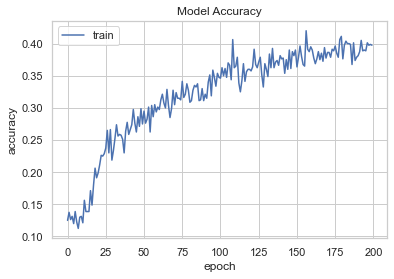

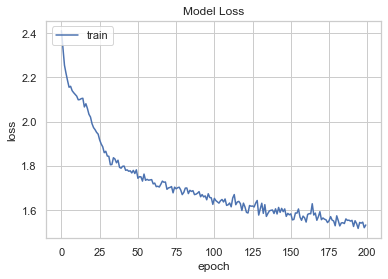

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4
0,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.940000e-05,0.000807,0.005043,0.017085,0.006280,0.028408,0.328119,0.448926,0.416039,0.536846
1,adhy,pizza,0.159790,-0.047984,0.111806,0.087697,0.247487,0.135681,0.023842,0.159523,...,9.412329e-03,0.006395,0.062381,0.045333,0.097017,0.079969,0.423147,0.582937,0.551112,0.710902
2,adhy,yahoo,0.119425,0.015744,0.135168,0.136153,0.255577,0.120409,-0.040412,0.079997,...,3.720000e-07,0.000002,0.006328,0.005632,0.000610,0.001306,0.335316,0.454740,0.408114,0.527538
3,adhy,ogler,0.072609,0.719367,0.791976,0.846915,0.919525,0.127549,-0.047783,0.079765,...,3.322198e-01,0.288946,0.525115,0.486267,0.576385,0.537537,1.078749,1.151358,1.166748,1.239357
4,adhy,cheat,0.120612,-0.056471,0.064141,0.079218,0.199830,0.135689,0.023985,0.159674,...,3.054200e-04,0.000046,0.034640,0.045301,0.017476,0.006815,0.352062,0.472674,0.439222,0.559834


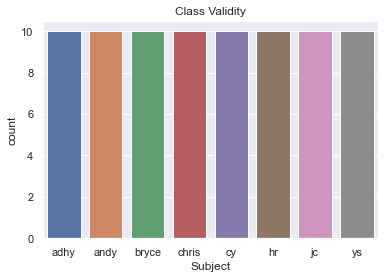

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model: " + str(match_header))

Accuracy of the Model: 21/80 (26.25%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:08:29
